In [9]:
# a. import
import ipywidgets as widgets
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from HouseholdSpecializationModel import *
import math


In [3]:
# Lister med alpha og sigma værdier til loop
alpha_values = [0.25, 0.5, 0.75]
sigma_values = [0.5, 1, 1.5]

In [4]:
#Returner H forhold for loop over alpha og sigma værdier
H_div = []

for i,j in zip(alpha_values, sigma_values):
    model = HouseholdSpecializationModelClass()
    model.par.alpha = i
    model.par.sigma = j 
    opt = model.solve_discrete()
    H_div.append(opt.HF/opt.HM)
print(H_div)

[0.3076923076923077, 1.0, 3.25]


Text(0.5, 0, 'H_div')

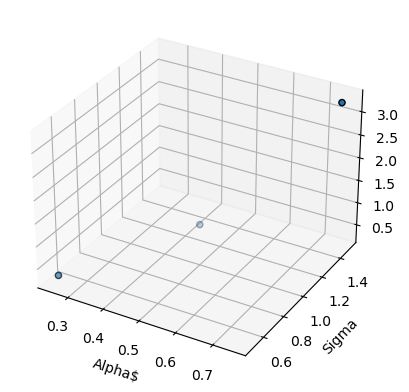

In [8]:
#plot for alpha og sigma værdier

# a. Answer
fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection='3d')
ax.scatter3D(alpha_values, sigma_values, H_div ,edgecolor='black')

# b. add labels
ax.set_xlabel('Alpha')
ax.set_ylabel('Sigma')


Question 2:


In [13]:
#Returner H forhold for loop over alpha og sigma værdier
H_div_log = []

for i,j in zip(alpha_values, sigma_values):
    model = HouseholdSpecializationModelClass()
    model.par.alpha = i
    model.par.sigma = j 
    opt = model.solve_discrete()
    H_div_log.append(math.log(opt.HF/opt.HM))
print(H_div_log)


[-1.1786549963416462, 0.0, 1.1786549963416462]


In [22]:
# Forhold mellem WF og WM
wF_values = [0.8, 0.9, 1.0, 1.1, 1.2]
wM = 1.0
Log_ratio = []

for wF in wF_values:
    model = HouseholdSpecializationModelClass()
    model.par.wF = wF
    model.par.wM = wM
    opt = model.solve_discrete()
    Log_ratio.append(math.log(wF/wM))
    print(Log_ratio)

[-0.2231435513142097]
[-0.2231435513142097, -0.10536051565782628]
[-0.2231435513142097, -0.10536051565782628, 0.0]
[-0.2231435513142097, -0.10536051565782628, 0.0, 0.09531017980432493]
[-0.2231435513142097, -0.10536051565782628, 0.0, 0.09531017980432493, 0.1823215567939546]
